In [149]:
from collections import deque

import cv2
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

In [150]:
import warnings
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

In [151]:
IN_DIR = "/Users/loblium/data/pp/"
OUT_DIR = "/Users/loblium/data/ptv/"

In [152]:
class Vector2D(object):
    def __init__(self, idx):
        self.idx = idx
        self.x = 0.0
        self.y = 0.0


class Gap(object):
    def __init__(self, idx):
        self.idx = idx
        self.gap = 0.0
        self.angle = 0.0


class TP(object):
    def __init__(self, idx):
        self.idx = idx
        self.p0 = 0
        self.p1 = 0
        self.err = 0.0
        self.flag = False


def calc_gap(dx1, dx2):
    gx = Vector2D
    dst = Gap

    gx.x = dx2.x - dx1.x
    gx.y = dx2.y - dx1.y
    dst.gap = np.sqrt(gx.x ** 2 + gx.y ** 2)

    in_prod = dx1.x * dx2.x + dx1.y * dx2.y
    if np.sqrt(dx1.x ** 2 + dx1.y ** 2) * np.sqrt(dx2.x ** 2 + dx2.y ** 2) == 0:
        in_prod /= 1e-8
    else:
        in_prod /= np.sqrt(dx1.x ** 2 + dx1.y ** 2) * np.sqrt(dx2.x ** 2 + dx2.y ** 2)

    if np.abs(in_prod) > 1.0: in_prod /= np.abs(in_prod)

    dst.angle = np.arccos(in_prod)

    out_prod = dx1.x * dx2.y - dx1.y * dx2.x
    if out_prod < 0: dst.angle *= -1

    return dst, in_prod, out_prod


def ptv3t(img):
    pp0, pp1, pp2 = img[0], img[1], img[2]

    if pp0 is None or pp1 is None or pp2 is None:
        return None

    result = np.zeros([pp0.shape[0], 6])

    dx = [Vector2D(idx=x) for x in range(2)]
    dst = [Gap(idx=x) for x in range(1)]
    pp01 = [TP(idx=x) for x in range(pp0.shape[0])]
    s1, s2 = 10, 5  # 1st, 2nd search window
    eta = 15 * np.pi / 180  # criterion on angle
    npa = -1  # the number of available particle
    ntsp = 0  # the number for tracking the same particle

    # 3 times tracking
    for ii in range(pp0.shape[0]):  # Target (= 0th)
        flag = True  # init flag for the particle tracking
        cf, cfc = 1e10, 1e10  # arbitrary large number

        for jj in range(pp1.shape[0]):  # 1st
            dx[0].x = pp1[jj][0] - pp0[ii][0]
            dx[0].y = pp1[jj][1] - pp0[ii][1]

            if np.sqrt(dx[0].x ** 2 + dx[0].y ** 2) <= s1:
                for kk in range(pp2.shape[0]):  # 2nd
                    dx[1].x = pp2[kk][0] - pp1[jj][0]
                    dx[1].y = pp2[kk][1] - pp1[jj][1]

                    dst[0], ip0, op0 = calc_gap(dx[0], dx[1])
                    cfc = dst[0].gap ** 2

                    if dst[0].gap <= s2 and np.abs(dst[0].angle) <= eta and cfc < cf:
                        cf = cfc
                        if flag: npa += 1

                        pp01[npa].p0 = ii
                        pp01[npa].p1 = jj
                        pp01[npa].err = cf
                        pp01[npa].flag = True
                        flag = False

    # post-processing
    # If different particles track the same particle,
    # giving an error flag to particle which has larger error.
    for ii in range(npa):
        if pp01[ii].flag:
            for jj in range(ii + 1, npa):
                if pp01[ii].p1 == pp01[jj].p1:
                    if pp01[ii].err > pp01[jj].err:
                        pp01[ii].flag = False
                        ntsp += 1
                        break
                    else:
                        pp01[jj].flag = False
                        ntsp += 1

    # for debug
    # print(f"The number for tracking the same particle: {ntsp}")
    # print(f"The number of remaining particle by post processing: {npa - ntsp}\n")

    for ii in range(npa):
        if pp01[ii].flag:
            result[ii][0] = pp0[pp01[ii].p0][0]
            result[ii][1] = pp0[pp01[ii].p0][1]
            result[ii][2] = pp1[pp01[ii].p1][0] - pp0[pp01[ii].p0][0]
            result[ii][3] = pp1[pp01[ii].p1][1] - pp0[pp01[ii].p0][1]
            result[ii][4] = pp01[ii].p0
            result[ii][5] = pp01[ii].p1

    return result[:npa]

In [153]:
ptv_result = [np.zeros((1, 6))] * 11

In [154]:
for d in range(1, 4):
    if d == 1 or d == 2 or d == 4 or d == 5: continue

    data_list = deque([None, None, None])

    for i in tqdm(range(0, 3900, 1)):
        data_list.popleft()

        try:
            if d == 3:
                tmp = np.loadtxt(IN_DIR + f"{d}/{i}.csv", delimiter=',', skiprows=1)
            else:
                tmp = np.loadtxt(IN_DIR + f"{d}/pp_{i}.csv", delimiter=',', skiprows=1)
        except StopIteration:
            tmp = None

        if tmp is None:
            pass
        elif tmp.ndim == 1:
            if len(tmp) > 0:
                tmp = tmp[np.newaxis, :]
            else:
                tmp = None
        elif tmp.ndim == 2:
            pass
        else:
            tmp = None

        data_list.append(tmp)

        r = ptv3t(img=data_list)
        if r is None:
            pass
        else:
            ptv_result[d] = np.vstack([ptv_result[d], r])
            np.savetxt(OUT_DIR +f"{d}/{i}.csv", r, delimiter=',', header="x, y, dx, dy, p0_id, p1_id")

100%|██████████| 3900/3900 [00:29<00:00, 130.77it/s]


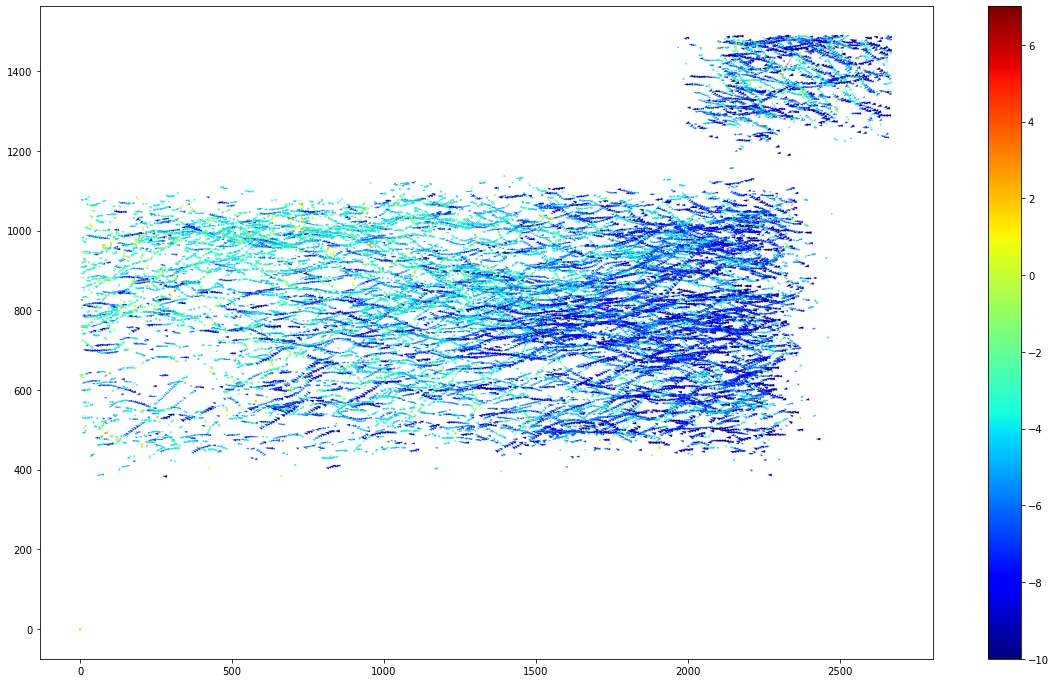

In [155]:
fig, ax = plt.subplots(figsize=(20, 12))
c = ax.quiver(ptv_result[3][:, 0], ptv_result[3][:, 1], ptv_result[3][:, 2], -ptv_result[3][:, 3], ptv_result[3][:, 2], cmap="jet")
fig.colorbar(c)
plt.show()

In [156]:
post = ptv_result[3]

In [157]:
post[post[:, 1] > 1200] = np.nan

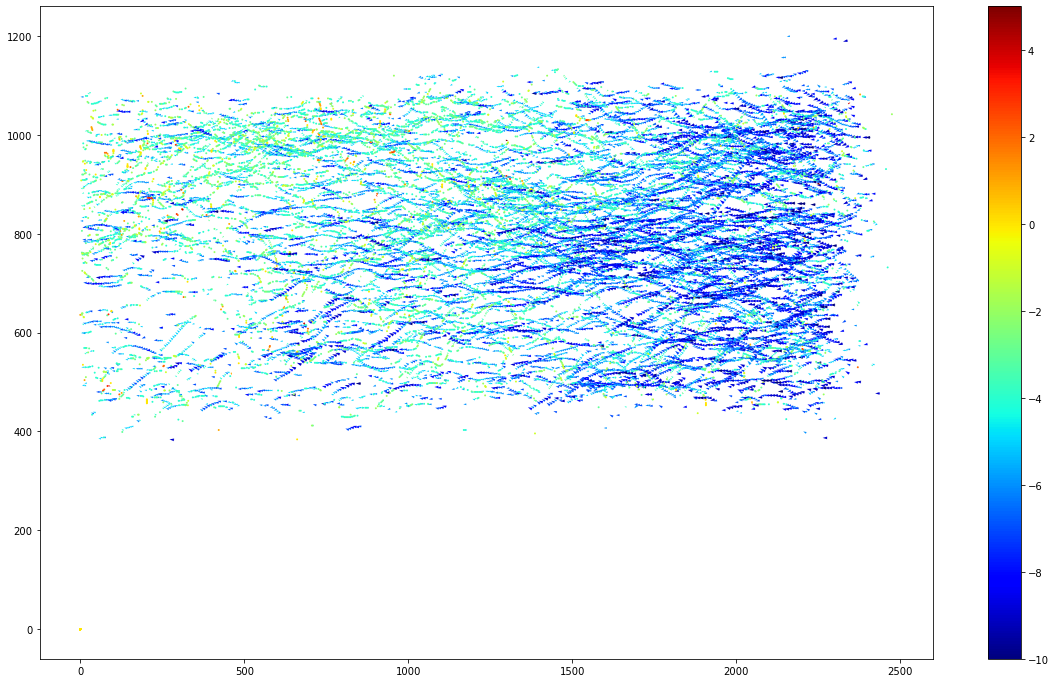

In [158]:
fig, ax = plt.subplots(figsize=(20, 12))
c = ax.quiver(post[:, 0], post[:, 1], post[:, 2], -post[:, 3], post[:, 2], cmap="jet")
fig.colorbar(c)
plt.show()

In [159]:
px_to_m = 10 / 34 / 1e3

In [160]:
post[:, 0] = 2704 - post[:, 0]
post[:, 1] = 1520 - post[:, 1]

In [161]:
post[:, 0] = post[:, 0] + 378
post[:, 1] = post[:, 1] - 675

In [162]:
post *= px_to_m
post[:, 2:] *= 120

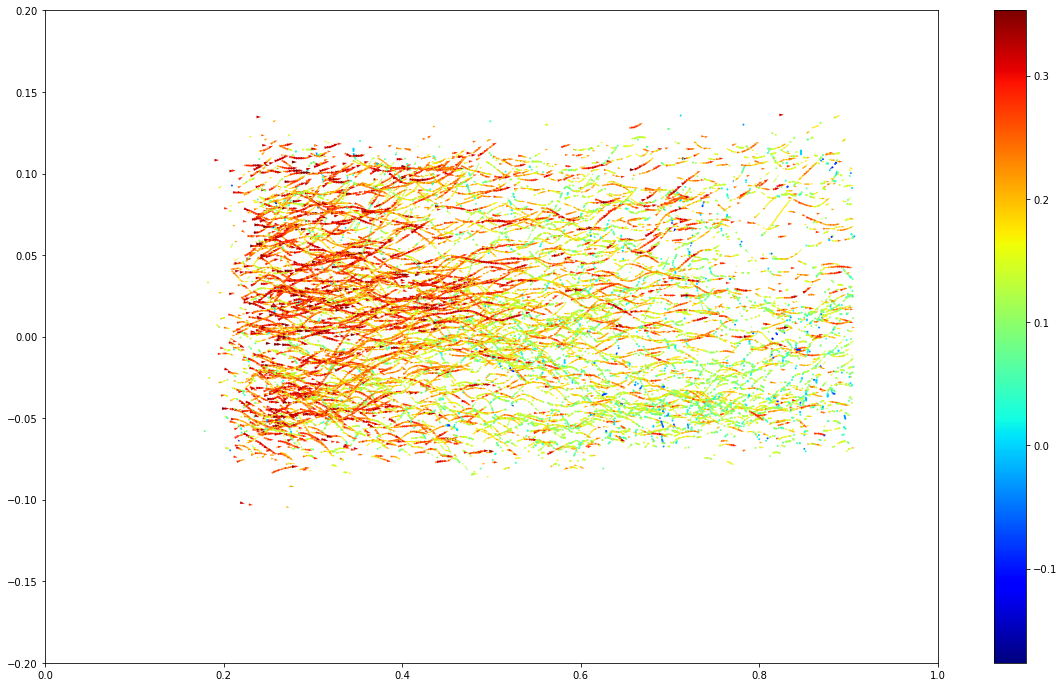

In [163]:
fig, ax = plt.subplots(figsize=(20, 12))
plt.xlim(0, 1.0)
plt.ylim(-0.2, 0.2)
c = ax.quiver(post[:, 0], post[:, 1], -post[:, 2], -post[:, 3], -post[:, 2], cmap="jet")
fig.colorbar(c)
plt.show()

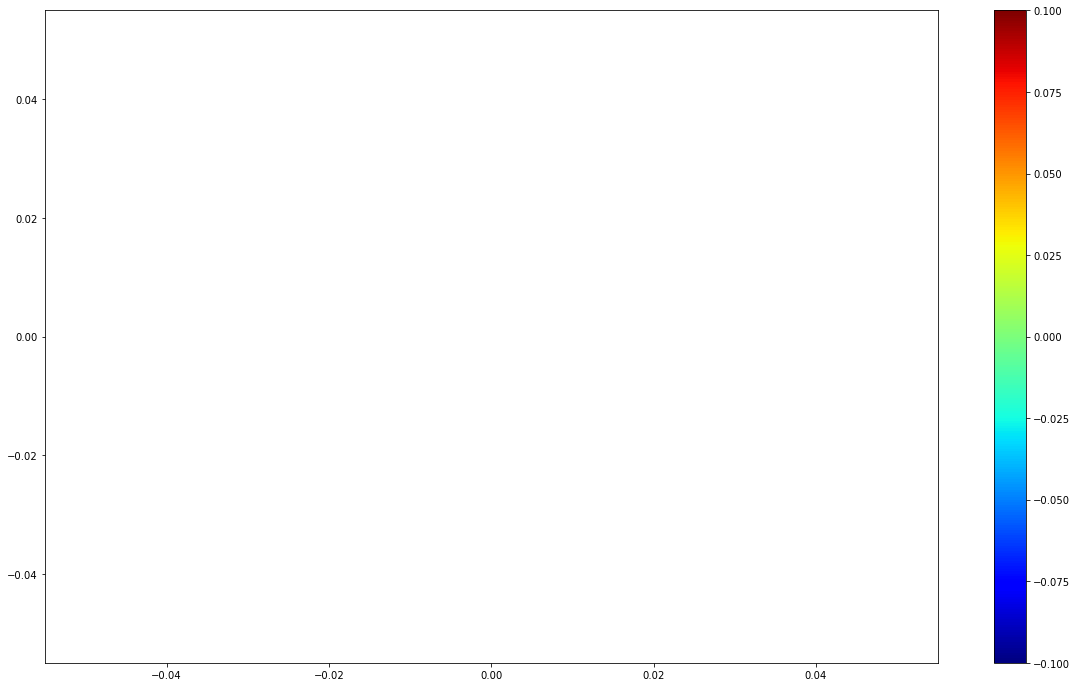

In [164]:
fig, ax = plt.subplots(figsize=(20, 12))
c = ax.quiver(ptv_result[6][:, 0], ptv_result[6][:, 1], ptv_result[6][:, 2], -ptv_result[6][:, 3], ptv_result[6][:, 2], cmap="jet")
fig.colorbar(c)
plt.show()

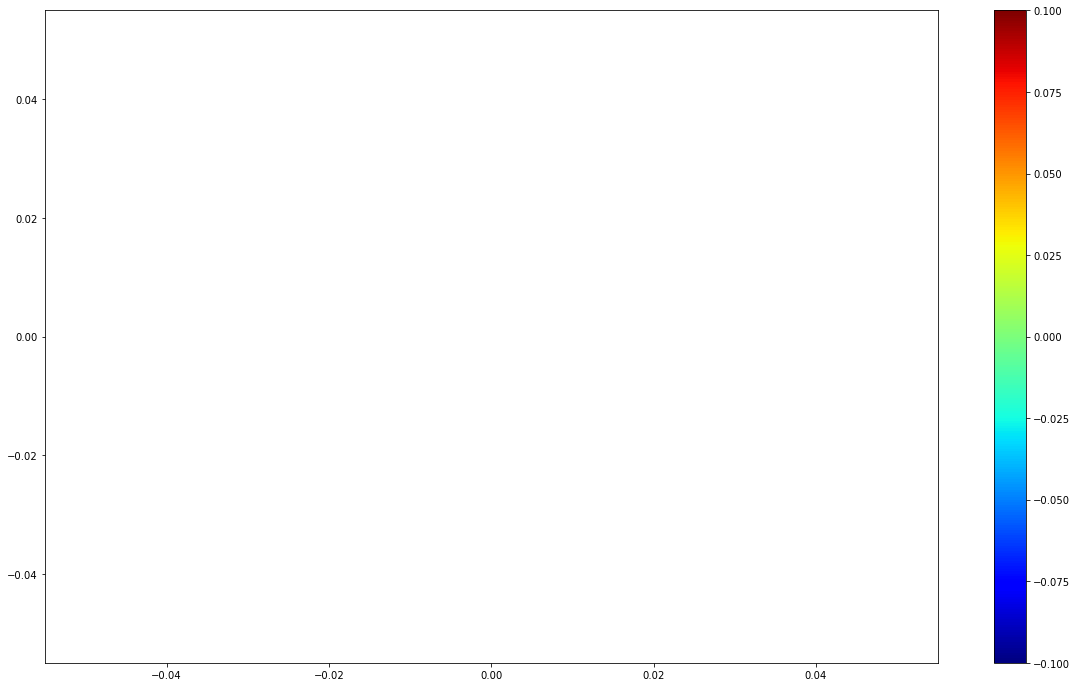

In [165]:
fig, ax = plt.subplots(figsize=(20, 12))
c = ax.quiver(ptv_result[7][:, 0], ptv_result[7][:, 1], ptv_result[7][:, 2], -ptv_result[7][:, 3], ptv_result[7][:, 2], cmap="jet")
fig.colorbar(c)
plt.show()

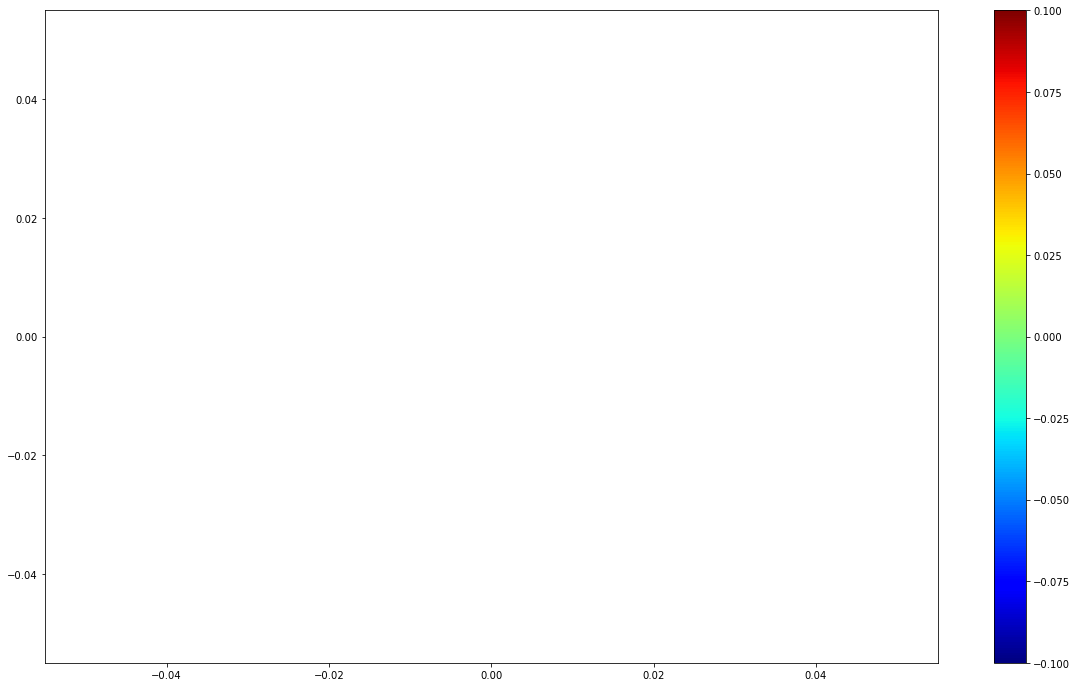

In [166]:
fig, ax = plt.subplots(figsize=(20, 12))
c = ax.quiver(ptv_result[8][:, 0], ptv_result[8][:, 1], ptv_result[8][:, 2], -ptv_result[8][:, 3], ptv_result[8][:, 2], cmap="jet")
fig.colorbar(c)
plt.show()

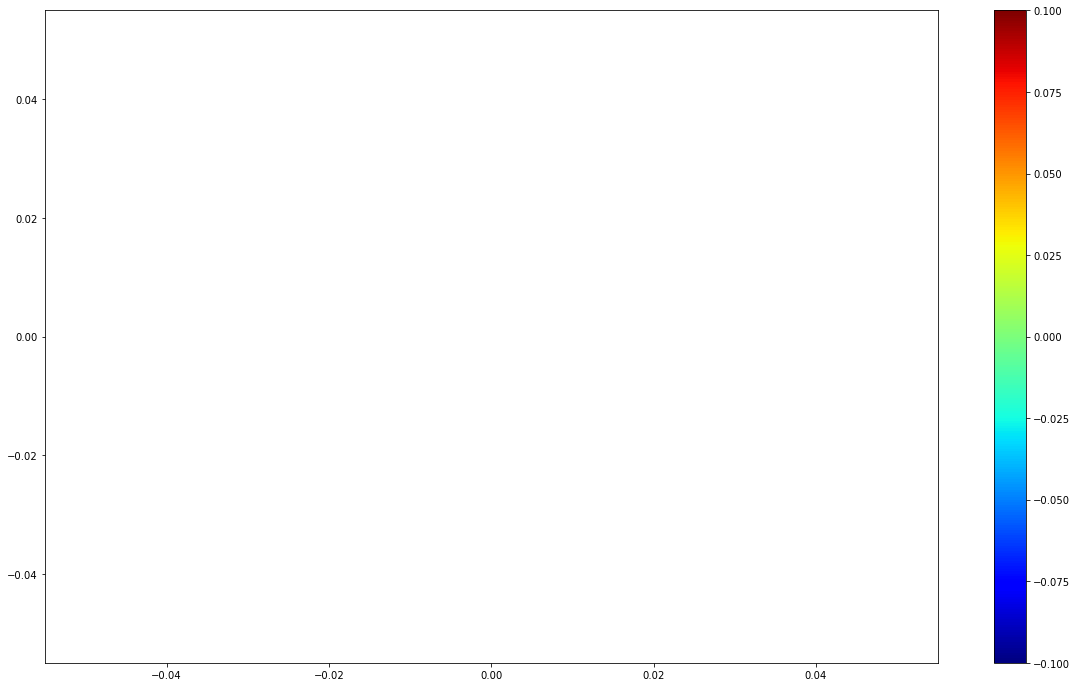

In [167]:
fig, ax = plt.subplots(figsize=(20, 12))
c = ax.quiver(ptv_result[9][:, 0], ptv_result[9][:, 1], ptv_result[9][:, 2], -ptv_result[9][:, 3], ptv_result[9][:, 2], cmap="jet")
fig.colorbar(c)
plt.show()

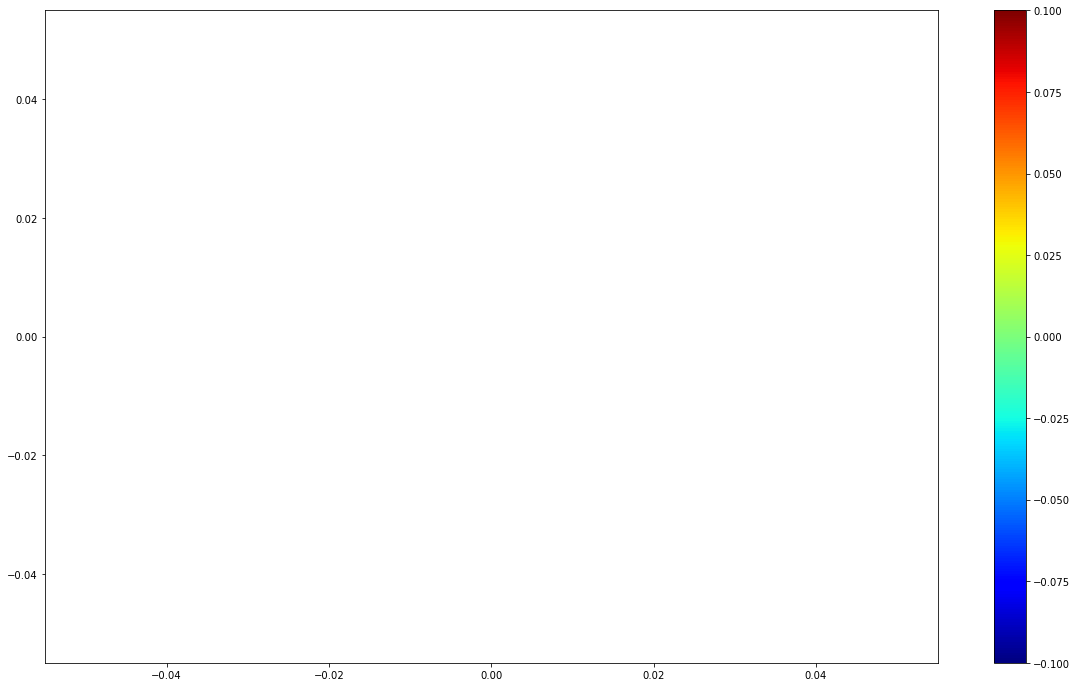

In [168]:
fig, ax = plt.subplots(figsize=(20, 12))
c = ax.quiver(ptv_result[10][:, 0], ptv_result[10][:, 1], ptv_result[10][:, 2], -ptv_result[10][:, 3], ptv_result[10][:, 2], cmap="jet")
fig.colorbar(c)
plt.show()